### Load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# returns from Day-1/2
returns = pd.read_csv("../data/processed/market_returns.csv",
                      index_col=0, parse_dates=True)

rA = returns["AAPL"].dropna()

# spread from Day-4
prices = pd.read_csv("../data/processed/adj_close_AAPL_MSFT.csv",
                     index_col=0, parse_dates=True)
spread = np.log(prices["AAPL"]) - np.log(prices["MSFT"])
spread.name = "spread_AAPL_MSFT"


### Visual check for stationarity

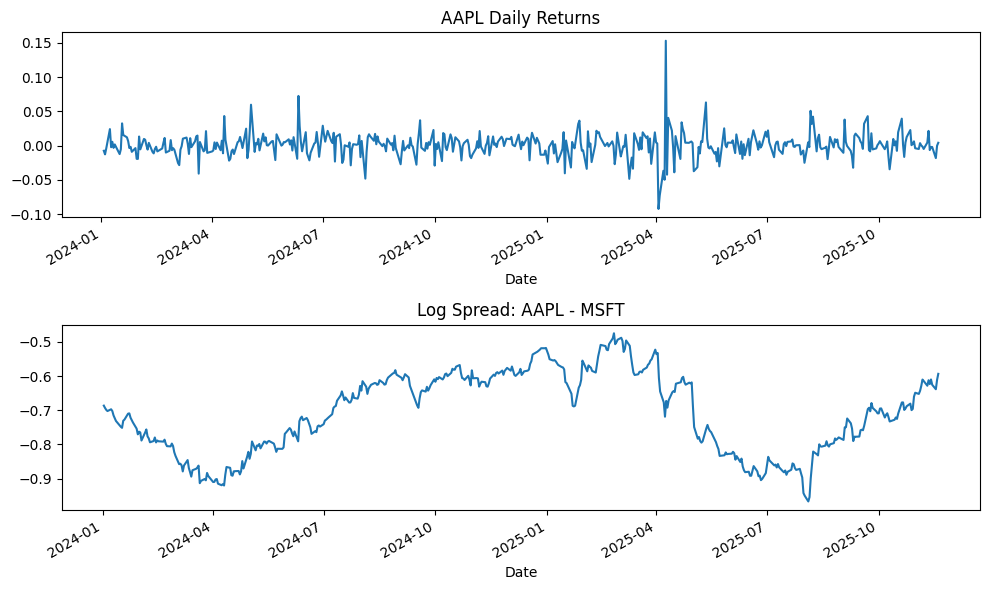

In [2]:
fig, axes = plt.subplots(2, 1, figsize=(10,6), sharex=False)

rA.plot(ax=axes[0], title="AAPL Daily Returns")
spread.plot(ax=axes[1], title="Log Spread: AAPL - MSFT")

plt.tight_layout()
plt.show()


Conclusion:
- returns ≈ mean around 0
- spread fluctuates around some band

### ACF plots

An ACF plot shows how much the current value of a time series is related (correlated) to its past values.
> This is called Autocorrelation.

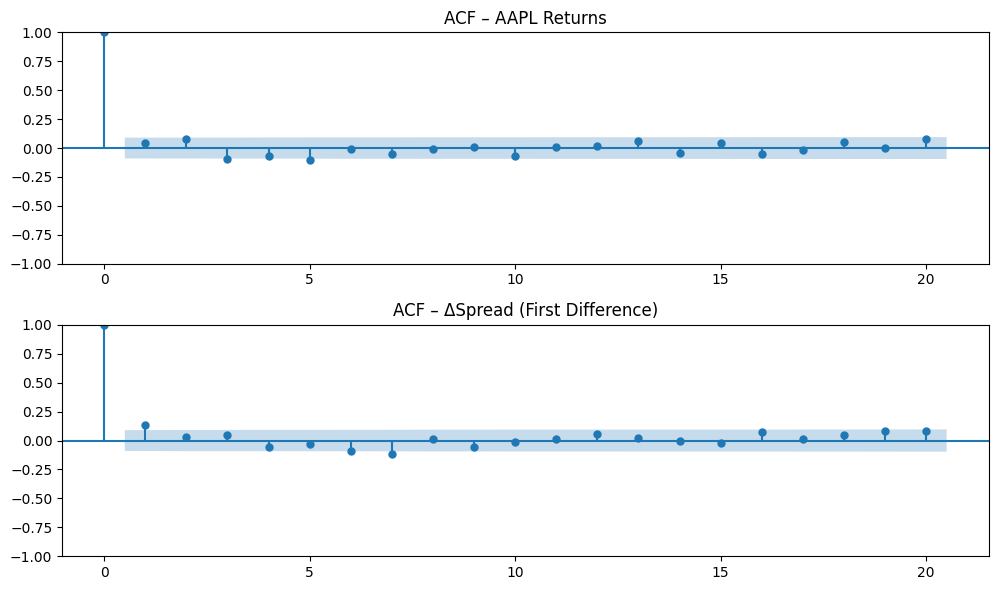

In [3]:
from statsmodels.graphics.tsaplots import plot_acf

fig, axes = plt.subplots(2, 1, figsize=(10,6))

plot_acf(rA.dropna(), ax=axes[0], lags=20)
axes[0].set_title("ACF – AAPL Returns")

plot_acf(spread.dropna().diff().dropna(), ax=axes[1], lags=20)
axes[1].set_title("ACF – ΔSpread (First Difference)")

plt.tight_layout()
plt.show()


Note:
- ACF of returns usually ~0 for most lags

- ACF of spread differences might show some structure

### Fit AR(1) model
An AR (Autoregressive) model is a statistical and machine learning technique that predicts future values in a time series by using its own past values.

In [9]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# original returns (AAPL)
series = rA.dropna()

# Reset index to 0,1,2,... for safety
series_pos = series.reset_index(drop=True)

print("Total observations:", len(series_pos))

# Guard: if too few points, skip
if len(series_pos) <= 2:
    print("Not enough data points to fit AR(1) and evaluate.")
else:
    # Fit AR(1) on the positional series
    model = AutoReg(series_pos, lags=1, old_names=False)
    res = model.fit()
    print(res.summary())

    # Predict from t=1 to t=n-1
    pred = res.predict(start=1, end=len(series_pos)-1)

    # Actual values aligned by position
    actual = series_pos.iloc[1:len(series_pos)]

    # Sanity check
    print("len(actual):", len(actual))
    print("len(pred):", len(pred))

    # Convert to NumPy arrays and compute MSE
    y_true = actual.to_numpy()
    y_pred = pred.to_numpy()

    mse = mean_squared_error(y_true, y_pred)
    print("MSE:", mse)

    # Directional accuracy
    direction_correct = np.sign(y_pred) == np.sign(y_true)
    acc = direction_correct.mean()
    print("Directional accuracy:", acc)


Total observations: 473
                            AutoReg Model Results                             
Dep. Variable:                   AAPL   No. Observations:                  473
Model:                     AutoReg(1)   Log Likelihood                1227.809
Method:               Conditional MLE   S.D. of innovations              0.018
Date:                Mon, 01 Dec 2025   AIC                          -2449.618
Time:                        13:52:23   BIC                          -2437.147
Sample:                             1   HQIC                         -2444.712
                                  473                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.133      0.257      -0.001       0.003
AAPL.L1        0.0428      0.046      0.931      0.352      -0.047       0.133
                            

Note:
> Here, Coefficient on lag1 (phi) = AAPL.L1 = 0.0428 -> phi is tiny, so returns are near white noise and very hard to predict.

### 1-step-ahead prediction & simple evaluation

MSE: 0.00032216161156706165
Directional accuracy: 0.5444915254237288


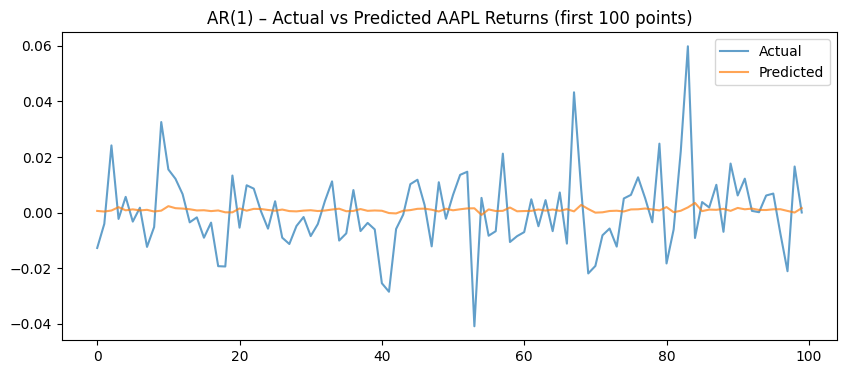

In [12]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Drop NaNs and reset index for clean positional modeling
series = rA.dropna()
series_pos = series.reset_index(drop=True)

# Fit AR(1)
model = AutoReg(series_pos, lags=1, old_names=False)
res = model.fit()

# Predict using positional indices
pred = res.predict(start=1, end=len(series_pos)-1)
actual = series_pos.iloc[1:len(series_pos)]

# Put both into a dataframe and drop any possible leftover NaN
df_eval = pd.DataFrame({
    'pred': pred,
    'actual': actual
}).dropna()

# Extract numpy arrays for sklearn metrics
y_pred = df_eval['pred'].values
y_true = df_eval['actual'].values

# Compute MSE
mse = mean_squared_error(y_true, y_pred)
print("MSE:", mse)

# Direction prediction
direction_correct = np.sign(y_pred) == np.sign(y_true)
acc = direction_correct.mean()
print("Directional accuracy:", acc)

# Plot first 100 comparison points
plt.figure(figsize=(10,4))
plt.plot(df_eval['actual'].values[:100], label='Actual', alpha=0.7)
plt.plot(df_eval['pred'].values[:100], label='Predicted', alpha=0.7)
plt.title("AR(1) – Actual vs Predicted AAPL Returns (first 100 points)")
plt.legend()
plt.show()


#### Although here, accuracy is very poor but we learned how to model returns.

### Future Reference: Check ACF of squared returns

Text(0.5, 1.0, 'ACF – Squared AAPL Returns')

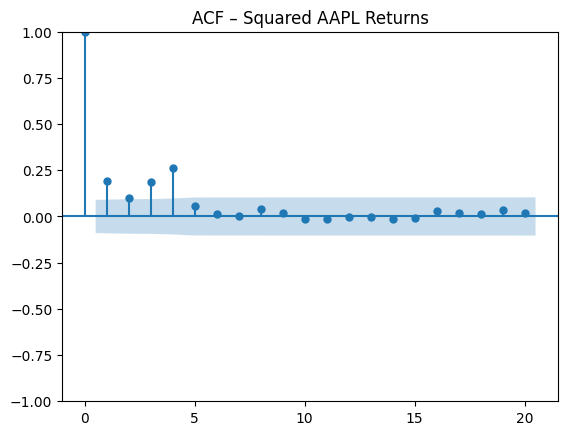

In [16]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf((rA**2).dropna(), lags=20)
plt.title("ACF – Squared AAPL Returns")

> We can see some volatility clustering here

### Test using the simple time series model file

In [18]:
import sys
sys.path.append("../src/python")

from models.time_series_models import AR1Model

ar1 = AR1Model()
ar1.fit(rA)
pred = ar1.predict(start=rA.index[1], end=rA.index[-1])

print(pred.head())


Date
2024-01-04   NaN
2024-01-05   NaN
2024-01-08   NaN
2024-01-09   NaN
2024-01-10   NaN
dtype: float64


c:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
